In [8]:
from firedrake import *
import numpy as np
from petsc4py import *
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
def TrueSolution(n,dt,T,parameters,useJP=False):
    mesh = UnitSquareMesh(n, n)
    
    order = 1
    V = FunctionSpace(mesh, "RT", order)
    Q = FunctionSpace(mesh, "DG", order-1)
    Z=V*Q

    VH = FunctionSpace(mesh, "CG", 1)

    up_ = Function(Z)
    up = Function(Z)

    vw = TestFunction(Z)
    
    utrue = Function(V)

    utrue0_str = "-x[0]*(1-x[0])*sin(t)"
    utrue1_str = "-x[1]*(1-x[1])*sin(t)"
    ptrue_str = "-2*(1-x[0]-x[1])*cos(t)"

    utrue_expr = Expression((utrue0_str, utrue1_str), t=0.0)
    
    ptrue = Function(Q)
    ptrue_expr = Expression(ptrue_str, t=0.0)
    
    ic = project(Expression((utrue0_str,utrue1_str,ptrue_str),t=0.0), Z)  #set to true solution to time t=0
    
    up_.assign(ic)
    up.assign(ic)

    u_, p_ = split(up_)
    u, p = split(up)
    v, w = split(vw)
    
    Theta = 0.5
    
    #dt = 1.0/n
    k = Constant(dt) 

    Forcing_expr = Expression(
        ("(2-x[0]+pow(x[0],2))*cos(t)",
         "(2-x[1]+pow(x[1],2))*cos(t)"),
        t=0.0)


    Forcing = Function(V)
    
    F = (
        (inner(v,(u-u_)))*dx
        - (inner(div(v),(Theta*p+(1-Theta)*p_))*k)*dx
        - (inner(w,(p-p_)))*dx
        - (inner(w,div(Theta*u+(1-Theta)*u_))*k)*dx
        - (inner(Forcing,v)*k)*dx
    )
    
    bcs = [DirichletBC(Z.sub(0), 0, (1,2,3,4))]
    time_array=[]
    energy_array=[]

    t = 0.0
    
    if useJP:
        uu, pp = TrialFunctions(Z)
        Jpc = (inner(v,uu)*dx + inner(w,pp)*dx)
    else:
        Jpc = None
    
    uerror_array = []
    perror_array = []

    while (t <= T):
        Forcing_expr.t = t+.5*dt
        utrue_expr.t = t+dt
        ptrue_expr.t = t+dt

        Forcing.project(Forcing_expr)

        time_array.append(t)
        solve(F == 0, up, bcs=bcs, Jp = Jpc,
              solver_parameters = parameters)
        up_.assign(up)

        u, p = up.split()
        
        utrue.project(utrue_expr)
        ptrue.project(ptrue_expr)
        
        uerror = sqrt(assemble(inner(u-utrue, u-utrue)*dx))
        uerror_array.append(uerror)

        perror = sqrt(assemble((p-ptrue)**2*dx))
        perror_array.append(perror)

        t += dt
    
    #plt.plot(time_array,uerror_array)
    #plt.plot(time_array,perror_array)
    #plt.show()
    return(time_array,uerror_array,perror_array)

In [3]:
solver_params={
    "snes_type": "ksponly",
    "mat_type": "aij",
    "ksp_type": "gmres",
    "pc_type": "lu"
}
n = 40
dt = 1.0/n
T = 10.0
#TrueSolution(n,dt,T,parameters,True)

TypeError: float() argument must be a string or a number, not 'builtin_function_or_method'

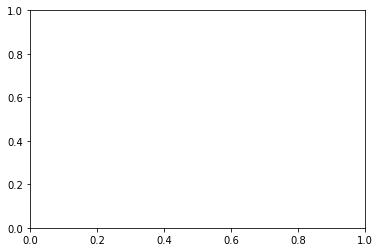

In [4]:
parameters = [{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "lu"},
{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "none"}]

iterations = []
n = [8]
T = 5.0
for param in parameters:
    for i in n:
        dt = 1.0/(i*i)
        time,uerror,_ = TrueSolution(i,dt,T,param,True)
        iterations.append(iter)
iterations = np.reshape(iterations,(2,int(len(iterations)*.5)))
#print(iterations)
plt.plot(n,iterations[0],label = 'Preconditioner')
plt.plot(n,iterations[1],label = 'None')
plt.legend()
#plt.xscale('log')
plt.show()

In [ ]:
parameters = [{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "lu"},
{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "none"}]

iterations = []
n = [8,16,32,64]
T = 5.0
for param in parameters:
    for i in n:
        dt = 1.0/(i)
        _,iter,_ = TrueSolution(i,dt,T,param,True)
        iterations.append(iter)
iterations = np.reshape(iterations,(2,int(len(iterations)*.5)))
#print(iterations)
plt.plot(n,iterations[0],label = 'Preconditioner')
plt.plot(n,iterations[1],label = 'None')
plt.legend()
#plt.xscale('log')
plt.show()

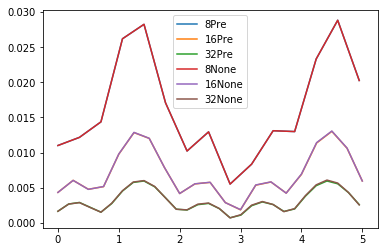

In [12]:
parameters = {"Pre":{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "lu"},
"None":{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "none"}}

iterations = []
n = [8,16,32]
T = 5.0

for param in parameters.keys():
    for i in n:
        dt = 1.0/(sqrt(i))
        time,iter,_ = TrueSolution(i,dt,T,parameters[param],True)
        plt.plot(time, iter, label = str(i)+param)
#print(iterations)
#plt.plot(n,iterations[0],label = n)
#plt.plot(n,iterations[1],label = 'None)
plt.legend()
#plt.xscale('log')
plt.show()

In [5]:
parameters = {"Pre":{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "lu"},
"None":{"snes_type": "ksponly",
              "mat_type": "aij",
              "ksp_type": "gmres",
              "pc_type": "none"}}

In [6]:
parameters.keys()

dict_keys(['Pre', 'None'])